In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
df=pd.read_csv('/content/deliveries.csv')

In [ ]:
# Step 1: Aggregate wickets taken by each bowler per match
bowler_wickets = df[df['is_wicket'] == 1].groupby(['match_id', 'bowler']).agg({'is_wicket': 'sum'}).reset_index()
bowler_wickets

,match_id,bowler,is_wicket
0,335982,AA Noffke,1
1,335982,AB Agarkar,3
2,335982,AB Dinda,2
3,335982,I Sharma,1
4,335982,JH Kallis,1
...,...,...,...
7773,1426312,MA Starc,2
7774,1426312,PJ Cummins,1
7775,1426312,SP Narine,1
7776,1426312,Shahbaz Ahmed,1


In [ ]:
# Step 2: Generate pseudo-dates for each match_id
unique_match_ids = bowler_wickets['match_id'].unique()
match_id_to_date = {mid: pd.Timestamp("2023-01-01") + pd.Timedelta(days=i) for i, mid in enumerate(unique_match_ids)}
bowler_wickets['date'] = bowler_wickets['match_id'].map(match_id_to_date)

# Step 3: Group by bowler and date
bowler_wickets = bowler_wickets.groupby(['bowler', 'date'])['is_wicket'].sum().reset_index()
bowler_wickets

,bowler,date,is_wicket
0,A Ashish Reddy,2023-10-09,2
1,A Ashish Reddy,2023-10-14,1
2,A Ashish Reddy,2023-10-16,1
3,A Ashish Reddy,2023-10-20,1
4,A Ashish Reddy,2023-10-24,1
...,...,...,...
7773,Z Khan,2024-08-04,3
7774,Z Khan,2024-08-08,3
7775,Z Khan,2024-08-17,2
7776,Z Khan,2024-09-19,2


In [ ]:
# Step 4: Forecast performance using SARIMA for each bowler
bowlers = bowler_wickets['bowler'].unique()
bowler_forecasts = {}

In [ ]:
for bowler in bowlers:

    # Filter data for the current bowler
    bowler_data = bowler_wickets[bowler_wickets['bowler'] == bowler]
    bowler_data = bowler_data.set_index('date')

    # Ensure consistent date frequency
    bowler_ts = bowler_data['is_wicket'].resample('D').sum().fillna(0)

    # Fit SARIMA model if there is sufficient data
    if len(bowler_ts) > 20:  # Ensure enough data points for reliable modeling
        model = SARIMAX(bowler_ts, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7))
        results = model.fit(disp=False)

        # Forecast wickets for the next 10 matches (or days)
        forecast = results.get_forecast(steps=10).predicted_mean.sum()
        bowler_forecasts[bowler] = forecast

# Step 5: Rank bowlers based on forecasted wickets
# Higher wickets = better performance, so sort descending
top_bowlers = sorted(bowler_forecasts.items(), key=lambda x: x[1], reverse=True)
top_bowlers

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/pyt

[('S Kaushik', 35.847132036025414),
 ('JW Hastings', 28.000023104871048),
 ('TM Head', 28.000002405850513),
 ('Kamran Khan', 16.340067427977495),
 ('B Stanlake', 14.271391900091352),
 ('AL Menaria', 14.000039679001244),
 ('MK Lomror', 14.000017527485662),
 ('A Badoni', 14.000003264422368),
 ('KJ Abbott', 14.000001237827352),
 ('ND Doshi', 13.999993464150737),
 ('Abdul Samad', 13.999993238740624),
 ('B Geeves', 13.999992350575635),
 ('FA Allen', 13.999986973641695),
 ('AK Markram', 13.999978720700785),
 ('P Suyal', 13.999975477879465),
 ('GD Phillips', 13.99997253920737),
 ('MJ Henry', 13.999962015269233),
 ('SB Styris', 12.231699809121181),
 ('Rasikh Salam', 11.889051436841317),
 ('DJ Muthuswami', 11.49883054612761),
 ('OC McCoy', 11.467472445409463),
 ('MG Bracewell', 11.37960909951365),
 ('GC Viljoen', 11.287848439813054),
 ('Umar Gul', 10.63096145822303),
 ('Jaskaran Singh', 10.194570207501132),
 ('D Pretorius', 9.30875306966712),
 ('TS Mills', 9.231192872649029),
 ('HR Shokeen', 9.

In [ ]:
# Step 6: Display the top bowlers
print("Top Bowlers Based on Forecasted Wickets:")
for rank, (bowler, forecast) in enumerate(top_bowlers[:10], start=1):  # Display top 10
    print(f"{rank}. {bowler}: {forecast:.2f} wickets")

Top Bowlers Based on Forecasted Wickets:
1. S Kaushik: 35.85 wickets
2. JW Hastings: 28.00 wickets
3. TM Head: 28.00 wickets
4. Kamran Khan: 16.34 wickets
5. B Stanlake: 14.27 wickets
6. AL Menaria: 14.00 wickets
7. MK Lomror: 14.00 wickets
8. A Badoni: 14.00 wickets
9. KJ Abbott: 14.00 wickets
10. ND Doshi: 14.00 wickets


In [ ]:
# Step 7: Plotting the forecast for the top bowler
top_bowler = top_bowlers[0][0]  # Get the top bowler
top_bowler_data = bowler_wickets[bowler_wickets['bowler'] == top_bowler]
top_bowler_data = top_bowler_data.set_index('date')
top_bowler_ts = top_bowler_data['is_wicket'].resample('D').sum().fillna(0)

# Split into train and test sets
train_size = int(len(top_bowler_ts) * 0.8)
train, test = top_bowler_ts[:train_size], top_bowler_ts[train_size:]

# Fit SARIMA model on the training data
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7))
results = model.fit(disp=False)

# Make predictions
predictions = results.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


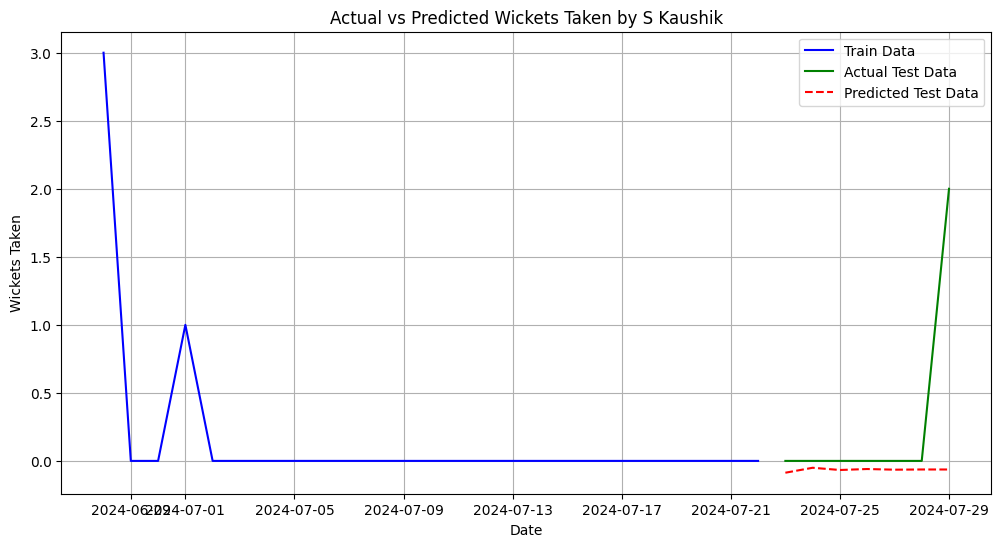

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train, label="Train Data", color="blue")
plt.plot(test, label="Actual Test Data", color="green")
plt.plot(test.index, predictions, label="Predicted Test Data", color="red", linestyle="--")
plt.title(f"Actual vs Predicted Wickets Taken by {top_bowler}")
plt.xlabel("Date")
plt.ylabel("Wickets Taken")
plt.legend()
plt.grid()
plt.show()